In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

#from pipeline.python.retinotopy import fit_2d_rfs as fitrf
#from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
#from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python import utils as putils #.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D



In [2]:
%matplotlib notebook

In [3]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

# Colors

In [4]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Dataset info

In [10]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = 'nstds' #'ROC' #None
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

#### RF fit params
response_type = 'dff'
# fit_thr=0.5

#### Set outputdir for current analysis
#fit_desc = fitrf.get_fit_desc(response_type=response_type)
# outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
# if not os.path.exists(outdir):
#     os.makedirs(outdir)
# print("... saving output to base dir:\n%s" % outdir)


In [11]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [12]:
#### Create data ID for labeling figures with data-types

filter_by = 'first'
has_gratings=False
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = '%s_%s_%s_resptest-%s_respthr-%.2f' % (response_type, filter_by, g_str, responsive_test, responsive_thr)

In [13]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|dff_first_blobsonly_resptest-nstds_respthr-10.00


In [14]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [15]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [16]:
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [17]:
sdata_blobs = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        'blobs' in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)])

#sdata_blobs = sdata[sdata['experiment']=='blobs'].copy()
sdata_blobs[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


In [18]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [19]:
blobmeta = aggr.get_blob_datasets(filter_by=filter_by, has_gratings=has_gratings, as_dict=True)
for k, v in blobmeta.items():
    print('%s: %i datasets' % (k, len(v)))

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [20]:
blobmeta

{'Li': ['20190605_JC090',
  '20190617_JC099',
  '20191018_JC113',
  '20191105_JC117',
  '20191111_JC120',
  '20190602_JC091',
  '20190606_JC091',
  '20190609_JC099',
  '20190502_JC076'],
 'Lm': ['20190525_JC084',
  '20190627_JC091',
  '20190618_JC097',
  '20190512_JC083',
  '20190504_JC078',
  '20190430_JC078',
  '20190506_JC080',
  '20190508_JC083'],
 'V1': ['20190522_JC084',
  '20190622_JC085',
  '20190613_JC097',
  '20190616_JC097',
  '20190617_JC097',
  '20191006_JC110',
  '20190420_JC076',
  '20190507_JC083']}

In [19]:
blobmeta

{'Li': ['20190605_JC090',
  '20190617_JC099',
  '20191018_JC113',
  '20191105_JC117',
  '20191111_JC120',
  '20190602_JC091',
  '20190614_JC091',
  '20190612_JC099'],
 'Lm': ['20190513_JC078',
  '20190603_JC080',
  '20190525_JC084',
  '20190627_JC091',
  '20190618_JC097',
  '20190512_JC083'],
 'V1': ['20190511_JC083',
  '20190522_JC084',
  '20190622_JC085',
  '20190613_JC097',
  '20190616_JC097',
  '20190617_JC097',
  '20191006_JC110']}

In [21]:
def melt_square_matrix(df, metric_name='value', include_diagonal=False):
    
    k = 0 if include_diagonal else 1
    df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

    df = df.stack().reset_index()
    df.columns=['row', 'col', metric_name]
    return df

In [22]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples


# Test 1 dataset

In [29]:
animalid = 'JC084'
session = '20190522'
fovnum = 1

responsive_test = 'nstds' #'ROC'
responsive_thr = 10 #0.05
n_stds=2.5

response_type = 'dff'
experiment = 'blobs'

In [32]:
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                      responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, n_stds=n_stds)
trialmeans = aggr.traces_to_trials(traces, labels, epoch='stimulus')

datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
182 of 260 cells responsive


<IPython.core.display.Javascript object>


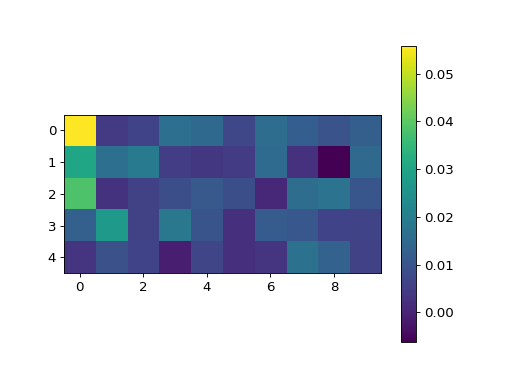

In [75]:
rid=39
tm = trialmeans.groupby(['config']).mean()[rid].reshape(10,5).T
pl.figure()
pl.imshow(tm)
pl.colorbar()

# Downsample, calculate activity correlations

In [23]:
# Temporal binning params
n_frames_bin = 11.
framerate = 44.65
new_framerate = framerate/n_frames_bin
print("Downsampled fr: %.2f Hz" % new_framerate)

# Pupil alignment params
#pre_ITI_ms=500
#post_ITI_ms=500 #pre_ITI_ms
#epoch='trial_alignment'

#### Get indices of trial epochs to model
#pre_flank = round((pre_ITI_ms/1E3)*44.65) #n_on/2.
#post_flank = round((post_ITI_ms/1E3)*44.65)  #n_on


Downsampled fr: 4.06 Hz


## Test w/ 1 fov

In [149]:
#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
nframes_per_trial = labels.groupby(['trial']).count().iloc[0][0]

#### Get indices of trial epochs to model
start_ix = 0 #int(stim_on-pre_flank)
end_ix = nframes_per_trial #int(stim_on + n_on + post_flank + 1)
#print(start_ix, end_ix, end_ix-start_ix)

#### Get resampled indices of trial epochs
_, out_ixs = resample_traces(np.arange(start_ix, end_ix), in_rate=44.65, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
new_n_on = int(round(n_on / 2.))

#### Get sample roi trace for dims
roi_list = traces.columns.tolist()


#roi_traces=[]
r_list=[]
for rid in roi_list:
    
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    #included_trials = [trial for trial, tg in labels.groupby(['trial'])]

    #### Bin traces - Each tbin is a column, each row is a sample 
    sample_data = trialmat.fillna(method='pad').copy()
    binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
    n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
    r_['config'] = cfg_list

    r_list.append(r_)
    
df = pd.concat(r_list, axis=1)
_, i = np.unique(df.columns, return_index=True)
df = df.iloc[:, i]

<IPython.core.display.Javascript object>


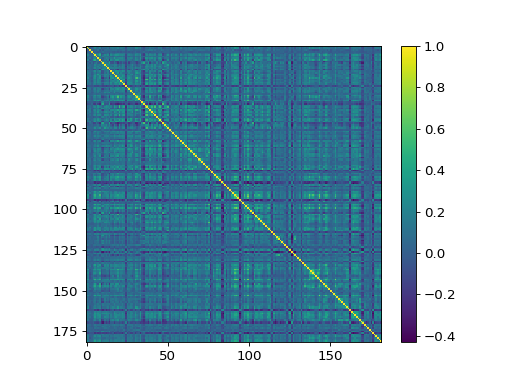

In [216]:
pl.figure()
pl.imshow(df[roi_list].corr())
pl.colorbar()

#### Check traces

In [205]:
rid = 5 #39 #roi_list[0]

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list


In [206]:
# Check with known config, known RID
ml=53 #-1
sz=10
print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])

          color morphlevel   object  size stimtype xpos ypos yrot
config026               53  morph53  10.0    image   20   -8    0


<IPython.core.display.Javascript object>


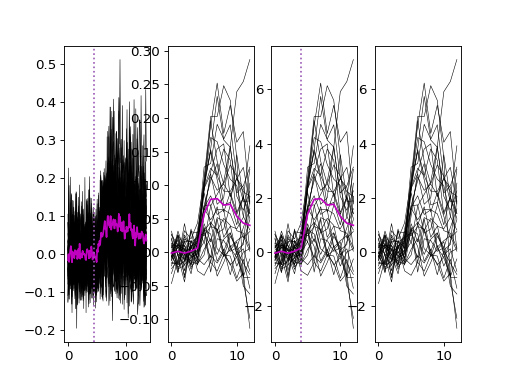

In [208]:
fig, axn = pl.subplots(1, 4)
ax=axn[0]
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=stim_on, ls=':')

ax=axn[1]
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm')

ax=axn[2]
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm')
ax.axvline(x=new_stim_on, ls=':')

ax=axn[3]
for tr, g in df[df['config']==cfg].groupby(['trial']):
    ax.plot(g[rid].values.T, 'k', lw=0.5)


# Load aggregate data

In [24]:
filter_str

'dff_first_blobsonly_resptest-nstds_respthr-10.00'

In [25]:
print(glob.glob(os.path.join(stats_dir, 'aggr_blobs_trialmeans*.pkl')))


['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_dff_unique_a_resptest-nstds_respthr-10.00.pkl']


In [26]:
print(glob.glob(os.path.join(stats_dir, 'aggr_blobs_binnedtraces*.pkl')))


['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_binnedtraces_dff_unique_a_resptest-ROC_respthr-0.05.pkl']


In [27]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_trialmeans*.pkl'))[0]
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)

In [28]:
aggr_binnedtraces_dfile = glob.glob(os.path.join(stats_dir, 'aggr_blobs_binnedtraces*.pkl'))[0]
with open(aggr_binnedtraces_dfile, 'rb') as f:
    BINNED = pkl.load(f)

In [29]:
def add_metadata(cc, vardict):
    nvals = cc.shape[0]
    for k, v in vardict.items():
        cc[k] = [v for _ in np.arange(0, nvals)]
    return cc

# Filter bad fovs

In [30]:
min_ncells=30
few_cells = []
for datakey, f in MEANS.items():
    print(datakey, f.shape)
    if f.shape[1] < min_ncells:
        few_cells.append(datakey)

('20190511_JC083_fov1', (1500, 127))
('20190613_JC097_fov1', (1500, 167))
('20190618_JC097_fov1', (1500, 117))
('20190512_JC083_fov1', (1575, 204))
('20191018_JC113_fov1', (2350, 65))
('20190622_JC085_fov1', (1500, 204))
('20190525_JC084_fov1', (1500, 161))
('20190603_JC080_fov1', (1500, 194))
('20190602_JC091_fov1', (1499, 242))
('20190522_JC084_fov1', (1500, 183))
('20190616_JC097_fov1', (1500, 297))
('20190612_JC099_fov1', (1500, 96))
('20190617_JC099_fov1', (973, 26))
('20191105_JC117_fov1', (1350, 80))
('20190614_JC091_fov1', (1500, 194))
('20190513_JC078_fov1', (1475, 136))
('20191111_JC120_fov1', (1500, 27))
('20190627_JC091_fov1', (1500, 170))
('20190605_JC090_fov1', (1635, 130))
('20190617_JC097_fov1', (1475, 281))
('20191006_JC110_fov1', (1675, 218))


In [31]:
excl = copy.copy(few_cells)
bad_targeting = ['20190605_JC090_fov1', '20191008_JC091_fov1']
excl.extend(bad_targeting)

In [32]:
excl

['20190617_JC099_fov1',
 '20191111_JC120_fov1',
 '20190605_JC090_fov1',
 '20191008_JC091_fov1']

## Calculate cross-cell correlations (trial means)

In [33]:
missing_data=[]
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] missing %s" % (visual_area, datakey))
        missing_data.append(datakey)
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in trialmeans.columns if putils.isnumber(r)]) 
    
    # Get across-cell correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(trialmeans[roi_list].corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

xcell_corrs = pd.concat(x_list, axis=0)
print(xcell_corrs.shape)
#print(missing_data)


[Li] missing 20190502_JC076_fov1
[Li] missing 20190606_JC091_fov1
[Li] missing 20190607_JC091_fov1
[Li] missing 20191008_JC091_fov1
[Li] missing 20190609_JC099_fov1
[Lm] missing 20190430_JC078_fov1
[Lm] missing 20190504_JC078_fov1
[Lm] missing 20190509_JC078_fov1
[Lm] missing 20190506_JC080_fov1
[Lm] missing 20190508_JC083_fov1
[Lm] missing 20190517_JC083_fov1
[V1] missing 20190420_JC076_fov1
[V1] missing 20190501_JC076_fov1
[V1] missing 20190507_JC083_fov1
[V1] missing 20190510_JC083_fov1
(312253, 8)


In [34]:
mean_xcell_coors = xcell_corrs[~xcell_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


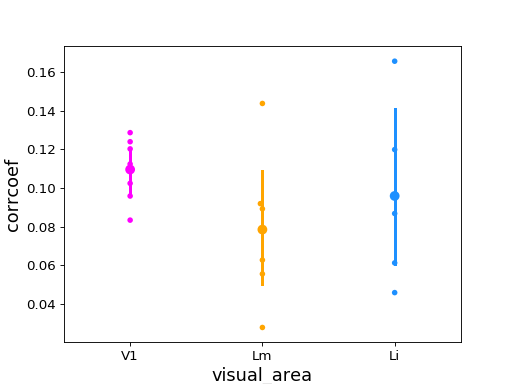

In [35]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_xcell_coors, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_xcell_coors, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


In [573]:
binned_traces.head()

,0,4,6,13,17,22,24,25,28,29,...,246,249,258,259,260,261,269,config,frame_ix,trial
0,-1.104270,0.240751,-0.468921,-0.167526,0.557166,-0.933853,0.029345,-0.746620,-0.716157,-0.544130,...,1.289263,-0.089074,0.393469,-0.328581,0.307535,1.601986,-0.748826,config025,-0.0,1
1,-0.325134,0.072006,0.140294,-0.216715,-0.461357,0.518616,-0.150089,-0.172219,-1.433950,-0.532226,...,-0.844529,0.829409,-0.941574,-0.002574,-0.262393,0.388382,0.540471,config025,1.0,1
2,0.824253,1.008800,-0.477036,1.190722,-0.113374,-0.751919,-0.067395,0.004333,1.759692,0.701984,...,-0.053214,-0.833590,0.442849,0.611521,0.268956,-0.413070,0.267265,config025,2.0,1
3,0.406172,-0.835128,1.106552,-0.815701,0.027234,0.971520,0.037839,0.944585,0.422795,0.470887,...,-0.395428,0.308259,0.049068,-0.097602,-0.221871,-1.451238,0.073141,config025,3.0,1
4,0.618550,1.022778,2.057574,0.039428,-0.186877,-0.213633,0.924704,1.856798,0.320492,0.112542,...,-0.645605,0.130550,2.661935,2.217748,-0.633607,1.429947,0.408620,config025,4.0,1


## Calculate cross-cell correlations, trial activity

In [36]:
  

#     BINNED[datakey] = df
    
#     tt = melt_square_matrix(df[roi_list].corr(), metric_name='corrcoef', include_diagonal=False)
#     tt_list.append(tt)

#missing_data=[]
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in BINNED.keys():
        #print("[%s] missing %s" % (visual_area, datakey))
        #missing_data.append(datakey)
        continue

    binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in binned_traces.columns if putils.isnumber(r)]) #r!='config'])
    
    # Get across-cell correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(binned_traces[roi_list].corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

activity_corrs = pd.concat(x_list, axis=0)
print(activity_corrs.shape)
#print(missing_data)


(312253, 8)
['20190502_JC076_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1', '20191008_JC091_fov1', '20190609_JC099_fov1', '20190430_JC078_fov1', '20190504_JC078_fov1', '20190509_JC078_fov1', '20190506_JC080_fov1', '20190508_JC083_fov1', '20190517_JC083_fov1', '20190420_JC076_fov1', '20190501_JC076_fov1', '20190507_JC083_fov1', '20190510_JC083_fov1']


In [37]:
#excl = [] #['20190617_JC099_fov1', '20191111_JC120_fov1']
mean_activity_corrs = activity_corrs[~activity_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()
#activity_corrs.groupby(['visual_area', 'datakey']).count()

<IPython.core.display.Javascript object>


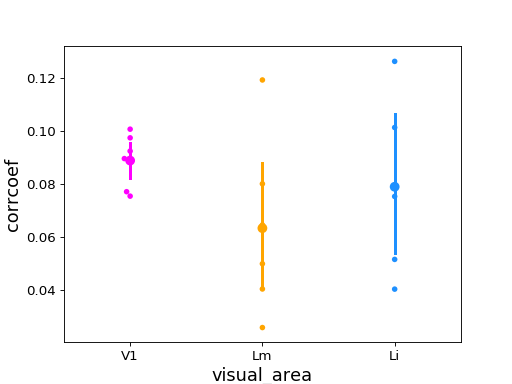

In [38]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_activity_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_activity_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


In [39]:
aggr.do_mannwhitney(mean_xcell_coors, metric='corrcoef')

[('V1', 'Lm')] p=0.151 (holm), reject H0=False
[('V1', 'Li')] p=0.417 (holm), reject H0=False
[('Lm', 'Li')] p=0.417 (holm), reject H0=False


[(('V1', 'Lm'), False, 0.15061874097915426),
 (('V1', 'Li'), False, 0.41679281184762706),
 (('Lm', 'Li'), False, 0.41679281184762706)]

In [40]:
aggr.do_mannwhitney(xcell_corrs, metric='corrcoef')

[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.000 (holm), reject H0=True


[(('V1', 'Lm'), True, 0.0),
 (('V1', 'Li'), True, 2.8330247511713111e-228),
 (('Lm', 'Li'), True, 3.4356315067362119e-310)]

In [41]:
xcell_corrs.groupby(['visual_area']).mean()

,row,col,corrcoef,fovnum
visual_area,,,,
Li,121.727080,238.616291,0.098819,1.0
Lm,98.197264,197.618954,0.073905,1.0
V1,110.628434,236.504961,0.115906,1.0


In [43]:
aggr.do_mannwhitney(activity_corrs, metric='corrcoef')

[('V1', 'Lm')] p=0.000 (holm), reject H0=True
[('V1', 'Li')] p=0.000 (holm), reject H0=True
[('Lm', 'Li')] p=0.000 (holm), reject H0=True


[(('V1', 'Lm'), True, 0.0),
 (('V1', 'Li'), True, 5.7982150718950617e-167),
 (('Lm', 'Li'), True, 0.0)]

In [44]:
activity_corrs.groupby(['visual_area']).mean()

,row,col,corrcoef,fovnum
visual_area,,,,
Li,121.727080,238.616291,0.081076,1.0
Lm,98.197264,197.618954,0.060681,1.0
V1,110.628434,236.504961,0.092085,1.0


## Calculate cross-trial corrs

In [45]:
#missing_data=[]
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    dict_key = '%s_%s' % (session, animalid)
#     if dict_key not in blobmeta[visual_area]:
#         print("[%s] skipping %s" % (visual_area, dict_key))
#         continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] missing %s" % (visual_area, datakey))
        #missing_data.append(datakey)
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    roi_list = np.array([r for r in trialmeans.columns if putils.isnumber(r)]) 
    
    # Get across-cell correlations by trial ('row' and 'col' are pairs of trials)
    cc = melt_square_matrix(trialmeans[roi_list].T.corr(), metric_name='corrcoef', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

xtrial_corrs = pd.concat(x_list, axis=0)
print(xtrial_corrs.shape)
#print(missing_data)


(24908724, 8)


In [46]:
mean_xtrial_corrs = xtrial_corrs[~xtrial_corrs['datakey'].isin(excl)].groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


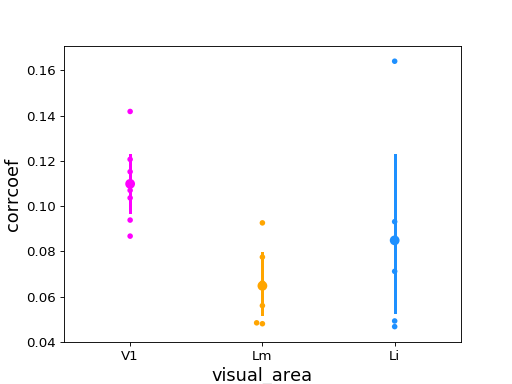

In [47]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_xtrial_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_xtrial_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


## Trial-to-trial correlations for each cell

In [48]:
animalid = 'JC084
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

binned_traces = BINNED[datakey] # shape: (ntrials_total, nrois_total)


In [49]:
binned_traces.head()

,1,2,5,6,7,9,10,11,12,14,...,243,245,246,249,251,255,258,config,frame_ix,trial
0,1.427362,0.142272,0.184416,-0.402909,-1.290077,-0.307582,0.033549,-0.107203,0.296352,0.594323,...,0.132575,-0.680102,0.669116,0.668401,-0.652988,0.111374,-0.132679,config032,-0.0,1
1,-0.056254,-0.700513,0.417106,1.321581,0.087162,-0.323059,0.005261,0.577349,-0.362820,0.437404,...,1.615885,-0.268813,0.464228,-0.080755,0.274998,-0.428206,0.359121,config032,1.0,1
2,-0.675176,0.730704,-0.490220,-0.205744,0.182782,-0.026686,0.795037,-0.403678,0.008165,-0.216715,...,-1.818583,0.229261,-0.932626,-0.720344,0.448792,0.776866,0.411194,config032,2.0,1
3,-0.362193,-0.133808,-0.078889,-0.566045,0.685913,0.640618,-0.742506,-0.219362,-0.159651,-0.684630,...,0.220674,0.528405,-0.412144,-0.046739,-0.082468,-0.401760,-0.487119,config032,3.0,1
4,-1.023217,-0.050785,-0.267804,-0.355633,0.512487,0.370633,1.236171,1.322756,0.513791,0.611006,...,-0.995413,-2.066888,0.747665,0.844226,-0.650700,-0.198234,2.521133,config032,4.0,1


In [54]:
obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [79]:
n_frames = len(sorted(tr['frame_ix'].unique()))
n_trials = len(sorted(tr['trial'].unique()))
print(n_frames, n_trials)

(13, 30)


In [97]:
config_array = np.reshape(sdf.index.tolist(), (10, 5))


In [101]:
tmat.shape

(30, 13)

<IPython.core.display.Javascript object>


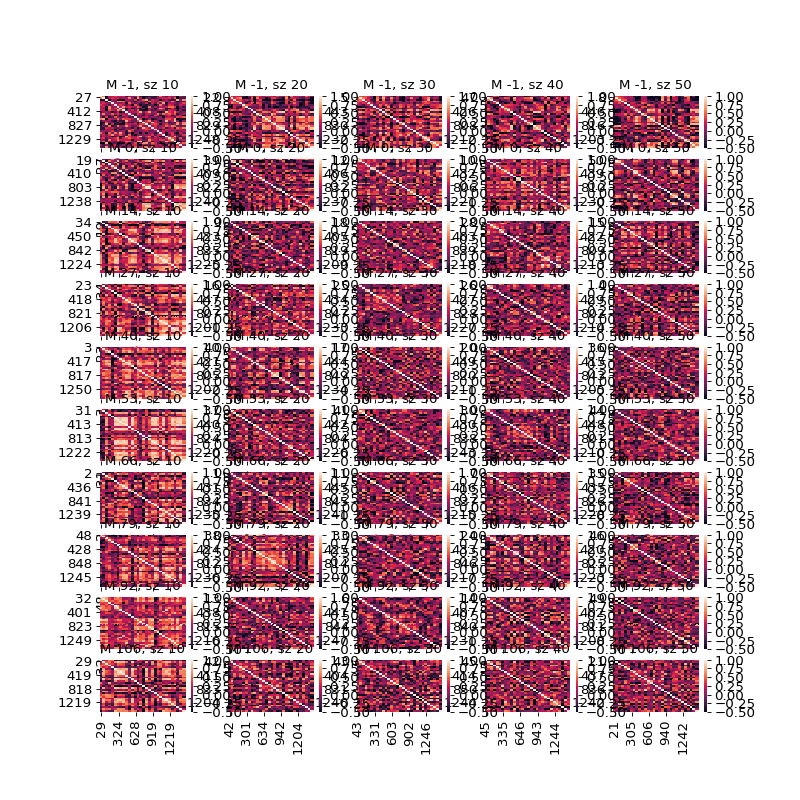

In [102]:
# cc_list = []
# fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
# for ax, cfg in zip(axn.flat, config_array.ravel()):
#     morphlevel = sdf['morphlevel'][cfg]
#     size = sdf['size'][cfg]
#     title_str = 'M %i, sz %i' % (morphlevel, size)
#     ax.set_title(title_str)
#     tr = binned_traces[binned_traces['config']==cfg] 
#     tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
#     t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))
    
#     cc = melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
#     cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
#     cc_list.append(cc)
    
#     sns.heatmap(t_df.corr(), ax=ax, vmin=-0.5, vmax=1.0)
    

In [123]:
binned_traces.head()

,1,2,5,6,7,9,10,11,12,14,...,243,245,246,249,251,255,258,config,frame_ix,trial
0,1.427362,0.142272,0.184416,-0.402909,-1.290077,-0.307582,0.033549,-0.107203,0.296352,0.594323,...,0.132575,-0.680102,0.669116,0.668401,-0.652988,0.111374,-0.132679,config032,-0.0,1
1,-0.056254,-0.700513,0.417106,1.321581,0.087162,-0.323059,0.005261,0.577349,-0.362820,0.437404,...,1.615885,-0.268813,0.464228,-0.080755,0.274998,-0.428206,0.359121,config032,1.0,1
2,-0.675176,0.730704,-0.490220,-0.205744,0.182782,-0.026686,0.795037,-0.403678,0.008165,-0.216715,...,-1.818583,0.229261,-0.932626,-0.720344,0.448792,0.776866,0.411194,config032,2.0,1
3,-0.362193,-0.133808,-0.078889,-0.566045,0.685913,0.640618,-0.742506,-0.219362,-0.159651,-0.684630,...,0.220674,0.528405,-0.412144,-0.046739,-0.082468,-0.401760,-0.487119,config032,3.0,1
4,-1.023217,-0.050785,-0.267804,-0.355633,0.512487,0.370633,1.236171,1.322756,0.513791,0.611006,...,-0.995413,-2.066888,0.747665,0.844226,-0.650700,-0.198234,2.521133,config032,4.0,1


In [128]:
t_list=[]
roi_list = [r for r in binned_traces.columns if putils.isnumber(r)]
for rid in roi_list:
    cc_list = []
    for cfg in config_array.ravel():
        tr = binned_traces[binned_traces['config']==cfg]
        tmat = np.reshape(tr[rid].values, (n_trials, n_frames)) # shape (ntrials, nframes)
        t_df = pd.DataFrame(data=tmat.T, columns=sorted(tr['trial'].unique()), index=sorted(tr['frame_ix'].unique()))

        cc = melt_square_matrix(t_df.corr(), metric_name='corrcoef', include_diagonal=False)
        cc['config'] = [cfg for _ in np.arange(0, cc.shape[0])]
        cc_list.append(cc)

    trialcorrs_by_cond = pd.concat(cc_list, axis=0)
    mean_trialcorrs_by_cond = trialcorrs_by_cond.groupby(['config']).mean()

    mean_trialcorrs_by_cond['rid'] = [rid for _ in np.arange(0, len(mean_trialcorrs_by_cond))]

    t_list.append(mean_trialcorrs_by_cond[['corrcoef', 'rid']].reset_index())


In [130]:
roi_trialcorrs = pd.concat(t_list,axis=0).reset_index(drop=True)
roi_trialcorrs.head()

,config,corrcoef,rid
0,config001,0.179017,1
1,config002,0.109830,1
2,config003,0.154946,1
3,config004,0.056117,1
4,config005,0.037183,1


In [ ]:
fig, axn = pl.subplots(config_array.shape[0], config_array.shape[1], figsize=(10,10))
for ax, cfg in zip(axn.flat, config_array.ravel()):
    morphlevel = sdf['morphlevel'][cfg]
    size = sdf['size'][cfg]
    title_str = 'M %i, sz %i' % (morphlevel, size)
    ax.set_title(title_str)
    sns.stripplot(x='rid', hue='rid', y='corrcoef', data=roi_trialcorrs[roi_trialcorrs['config']==cfg], ax=ax,
                 palette='hsv', dodge=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


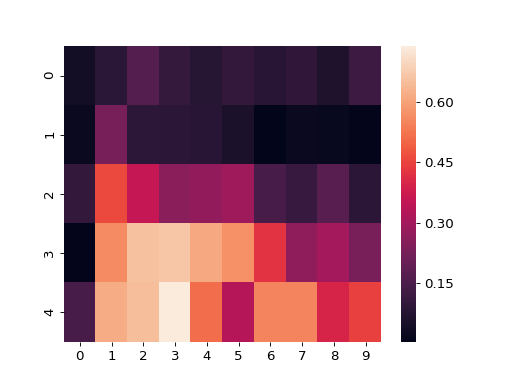

In [114]:
mean_arr = np.reshape(mean_trialcorrs_by_cond['corrcoef'].values,  (10, 5))
pl.figure()
sns.heatmap(mean_arr.T)

In [117]:
trialcorrs_by_cond.groupby(['config']).mean()['corrcoef']

config
config001    0.040676
config002    0.022633
config003    0.103710
config004    0.009802
config005    0.144697
config006    0.085546
config007    0.227992
config008    0.459587
config009    0.563107
config010    0.618802
config011    0.167865
config012    0.092455
config013    0.358904
config014    0.655752
config015    0.650971
config016    0.106063
config017    0.090412
config018    0.259414
config019    0.664617
config020    0.737968
config021    0.080897
config022    0.083446
config023    0.273189
config024    0.610131
config025    0.512388
config026    0.105210
config027    0.058996
config028    0.294971
config029    0.569545
config030    0.329529
config031    0.083698
config032    0.005084
config033    0.144325
config034    0.423990
config035    0.549911
config036    0.098340
config037    0.022719
config038    0.111811
config039    0.270357
config040    0.549095
config041    0.064536
config042    0.021742
config043    0.173135
config044    0.303451
config045    0.396363
con

## Correlation in tuning

In [403]:
x_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trialmeans = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    #roi_list = np.array([r for r in trialmeans.columns if r!='config'])
    tuning_ = trialmeans.groupby(['config']).mean().reset_index()
    cc = melt_square_matrix(tuning_.corr(), metric_name='corrcoef', include_diagonal=False)
    
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = add_metadata(cc, metadict)
    
    x_list.append(cc)

tuning_corrcoefs = pd.concat(x_list, axis=0).reset_index(drop=True)
    

In [496]:
tuning_.head()

,config,0,1,2,3,4,5,6,7,8,...,354,356,363,364,366,368,382,383,384,390
0,config001,0.022272,0.012470,0.032018,0.019996,-0.002374,0.025026,0.030313,0.062824,-0.004125,...,0.024384,0.013427,-0.017989,-0.006723,-0.006937,0.009262,0.010942,0.019144,0.014241,0.018341
1,config002,0.043768,0.010067,0.049354,0.034063,0.003447,0.023886,0.037885,0.080375,0.000026,...,0.027259,0.011974,-0.018280,0.025369,-0.011386,0.002855,0.001627,0.010361,0.037784,0.010730
2,config003,0.004631,-0.000607,0.021358,0.011231,0.009664,0.012752,0.026069,0.085406,-0.004788,...,0.009462,0.009184,0.002198,0.009228,-0.023146,-0.001677,0.000143,-0.000793,0.026244,0.008094
3,config004,-0.007940,0.004698,-0.008639,0.000882,0.004954,0.023512,0.004631,0.065532,-0.002017,...,0.019801,0.011921,-0.009219,-0.006480,-0.014104,0.006092,0.012280,0.004567,0.022511,0.004302
4,config005,-0.000528,0.004019,0.020715,0.017110,0.025549,0.017474,0.023336,0.063041,0.004888,...,0.011816,0.004288,-0.004853,0.016192,-0.020541,0.003888,0.012287,-0.002410,0.032363,0.005184


In [405]:
mean_tuning_corrs = tuning_corrcoefs.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


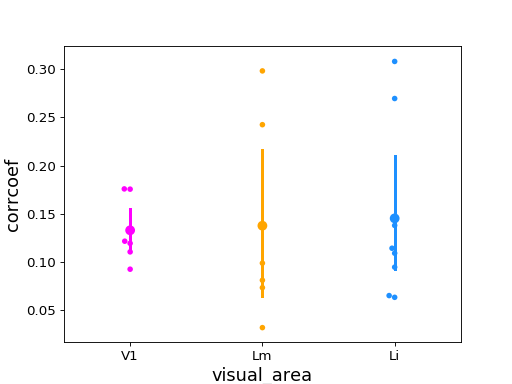

In [406]:
fig, ax = pl.subplots()
sns.swarmplot(x='visual_area', y='corrcoef', data=mean_tuning_corrs, ax=ax,
             order=visual_areas, palette=area_colors)
sns.pointplot(x='visual_area', y='corrcoef', data=mean_tuning_corrs, ax=ax,
             palette=area_colors, order=visual_areas, join=False)


## .. by distance

In [393]:
import scipy.spatial as spatial
from pipeline.python.rois.utils import load_roi_coords

In [375]:
r_list = []
for (visual_area, animalid, session, fovnum), g in sdata_blobs.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        #print("[%s] skipping %s" % (visual_area, datakey))
        continue
        
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)
    cc = fcoords['roi_positions'].copy()
    nvals = cc.shape[0]
    cc['animalid'] = [animalid for _ in np.arange(0, nvals)]
    cc['session'] = [session for _ in np.arange(0, nvals)]
    cc['fovnum'] = [fovnum for _ in np.arange(0, nvals)]
    cc['visual_area'] = [visual_area for _ in np.arange(0, nvals)]
    cc['datakey'] = [datakey for _ in np.arange(0, nvals)]
    
    r_list.append(cc)
    
roi_positions = pd.concat(r_list, axis=0)

... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


In [410]:
import math
def fastdist(v1, v2):
    dist = [(a - b)**2 for a, b in zip(v1, v2)]
    dist = math.sqrt(sum(dist))
    return dist

In [426]:
datakeys = tuning_corrcoefs['datakey'].unique()
roipos = roi_positions[roi_positions['datakey'].isin(datakeys)]

tuning_corrcoefs['distance'] = ''
for di, (datakey, curr_ccs) in enumerate(tuning_corrcoefs.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), len(datakeys)))
        
    #rpos = roipos[roipos['datakey']==datakey].copy()
    dists = [fastdist(roipos[roipos['datakey']==datakey].loc[c1][['ml_pos', 'ap_pos']].values.astype(float), 
                      roipos[roipos['datakey']==datakey].loc[c2][['ml_pos', 'ap_pos']].values.astype(float))
                for c1, c2 in curr_ccs[['row', 'col']].values]
    tuning_corrcoefs['distance'][curr_ccs.index] = dists


1 of 21 dsets
6 of 21 dsets
11 of 21 dsets
16 of 21 dsets
21 of 21 dsets


In [538]:
few_cells

['20190617_JC099_fov1', '20191111_JC120_fov1']

In [539]:
excl

['20190617_JC099_fov1',
 '20191111_JC120_fov1',
 '20190605_JC090_fov1',
 '20191008_JC091_fov1']

In [540]:
n_bins = 20

#tuning_corrcoefs['binned_dist'] = pd.cut(tuning_corrcoefs['distance'], n_bins, labels=False)
tuning_corrcoefs['binned_dist'] = pd.qcut(tuning_corrcoefs['distance'], n_bins, labels=False)
#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]


<IPython.core.display.Javascript object>


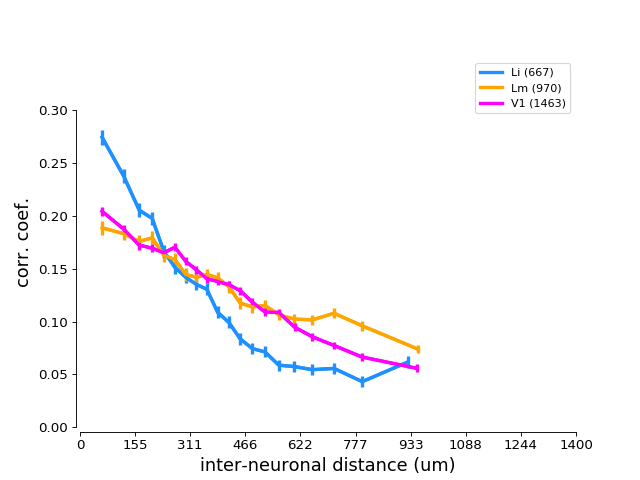

In [541]:
plotdf = tuning_corrcoefs[~tuning_corrcoefs['datakey'].isin(excl)].copy()

fig, ax = pl.subplots(figsize=(8,6))
for visual_area, currdf in plotdf.groupby(['visual_area']):

    
    ncells_t = sum([len(g['row'].unique()) for dk, g in currdf.groupby(['datakey'])])

    bin_dists = [b_df['distance'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_ccs = [b_df['corrcoef'].mean() for b, b_df in currdf.groupby(['binned_dist'])]    
    bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in currdf.groupby(['binned_dist'])]    
    
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=area_colors[visual_area], lw=3)
    
    xticks = np.linspace(0, 1400, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([int(b) for b in xticks])
    ax.set_xlabel('inter-neuronal distance (um)')
    ax.set_ylabel('corr. coef.')
ax.set_ylim([0, 0.35])
sns.despine(trim=True, offset=4)
ax.legend(bbox_to_anchor=(1., 1))

#### Split by fov

<IPython.core.display.Javascript object>


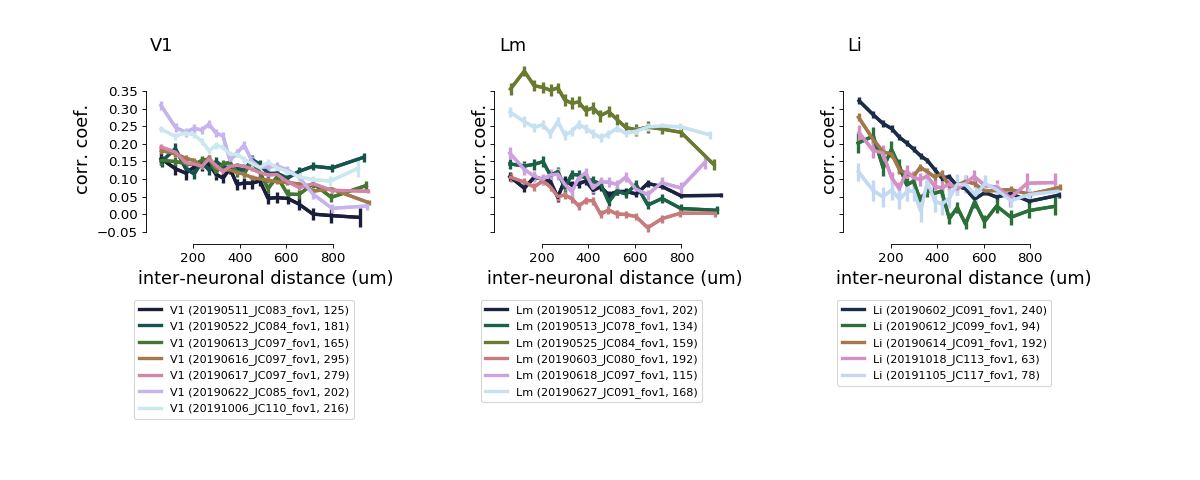

In [542]:
plotdf = tuning_corrcoefs[~tuning_corrcoefs['datakey'].isin(excl)].copy()

fig, axn = pl.subplots(1, 3, figsize=(15,6), sharex=True, sharey=True)
for ax, (visual_area, currdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):

    dcolors = sns.color_palette('cubehelix', n_colors=len(currdf['datakey'].unique()))
    
    for dcolor, (dkey, g) in zip(dcolors, currdf.groupby(['datakey'])):

        ncells_t = sum([len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])

        bin_dists = [b_df['distance'].mean() for b, b_df in g.groupby(['binned_dist'])]  
        bin_ccs = [b_df['corrcoef'].mean() for b, b_df in g.groupby(['binned_dist'])]
        bin_sems = [spstats.sem(b_df['corrcoef']) for b, b_df in g.groupby(['binned_dist'])]    

        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)

        #xticks = np.linspace(0, 1400, 10)
        #ax.set_xticks(xticks)
        #ax.set_xticklabels([int(b) for b in xticks])
        ax.set_xlabel('inter-neuronal distance (um)')
        ax.set_ylabel('corr. coef.')
        
    #ax.set_ylim([0, 0.06])
    sns.despine(trim=True, offset=4, ax=ax)
    ax.legend(bbox_to_anchor=(0.9, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    
pl.subplots_adjust(wspace=0.5, bottom=0.5)

In [469]:
bn

19